In [1]:
import pandas as pd
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
train_df=pd.read_pickle("./train_set.pkl")
test_df=pd.read_pickle("./test_set_all.pkl")
train_df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,wafer_size,failureNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,0,none,"(45, 48)",8
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,0,none,"(45, 48)",8
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,0,none,"(45, 48)",8
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,0,none,"(45, 48)",8
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,0,none,"(45, 48)",8


In [3]:
test_df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,wafer_size
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2,...",533.0,lot40328,1.0,1,"(26, 26)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot40328,2.0,1,"(26, 26)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2,...",533.0,lot40328,3.0,1,"(26, 26)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2,...",533.0,lot40328,4.0,1,"(26, 26)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot40328,5.0,1,"(26, 26)"


In [4]:
train_df["failureNum"].value_counts()

8    36730
3     8554
0     3462
2     2417
4     1620
5      609
6      500
1      409
7       54
Name: failureNum, dtype: int64

In [5]:
train_df["wafer_size"].value_counts()

(25, 27)    15684
(27, 25)     9235
(26, 26)     6369
(38, 36)     1877
(33, 37)     1804
            ...  
(67, 65)        1
(63, 63)        1
(52, 53)        1
(56, 63)        1
(53, 44)        1
Name: wafer_size, Length: 335, dtype: int64

In [6]:
print(train_df["waferMap"][1].shape)
print(train_df["wafer_size"][1])

(45, 48)
(45, 48)


In [7]:
def data_preprocessing(x_data, size, num_category, is_test = False, y_data = None):
    x = np.zeros((len(x_data), size, size, 1), dtype=np.float32)
    if is_test == False:
      y = np.zeros((len(x_data),num_category), dtype=np.uint8)
      for i, img in enumerate(x_data):
        x[i, :, :, :] = np.expand_dims(cv2.resize(img,(size, size)), axis=-1)
        y[i,y_data[i]] = 1

      return x, y
    else:
      for i, img in enumerate(x_data):
        x[i, :, :] = np.expand_dims(cv2.resize(img,(size, size)), axis=-1)
      
      return x

resize = 64
train_x, train_y = data_preprocessing(train_df["waferMap"].to_numpy(), resize, 9, False, train_df["failureNum"].to_numpy())


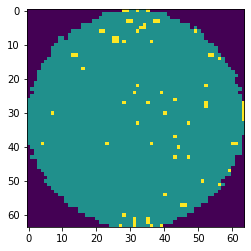

In [8]:
plt.imshow(train_x[5].astype(np.int32))

In [9]:
val_split = 0.2
num_val = math.floor(len(train_y)*val_split)
indice = np.arange(train_x.shape[0])
np.random.shuffle(indice)
train_x = train_x[indice]/255
train_y = train_y[indice]
partial_train_x = train_x[:-num_val]
val_x = train_x[-num_val:]
partial_train_y = train_y[:-num_val]
val_y = train_y[-num_val:]
print(partial_train_x.shape,partial_train_y.shape)
print(val_x.shape,val_y.shape)

(43484, 64, 64, 1) (43484, 9)
(10871, 64, 64, 1) (10871, 9)


In [10]:
def build_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(resize, resize, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='gelu'))
    model.add(layers.Dense(9,activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-3),
                  metrics=['acc'])

    return model

In [11]:
model = build_model()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                8

In [12]:
history = model.fit(
      partial_train_x,partial_train_y,
      batch_size=128,
      validation_data=(val_x,val_y),
      epochs=50,
      #verbose = 0
      )

Epoch 1/50
340/340 [==============================] - 8s 7ms/step - loss: 1.1140 - acc: 0.6761 - val_loss: 0.8164 - val_acc: 0.7366
Epoch 2/50
340/340 [==============================] - 2s 7ms/step - loss: 0.4636 - acc: 0.8735 - val_loss: 0.3566 - val_acc: 0.8984
Epoch 3/50
340/340 [==============================] - 2s 7ms/step - loss: 0.3263 - acc: 0.9052 - val_loss: 0.3058 - val_acc: 0.9135
Epoch 4/50
340/340 [==============================] - 2s 7ms/step - loss: 0.2634 - acc: 0.9219 - val_loss: 0.2181 - val_acc: 0.9336
Epoch 5/50
340/340 [==============================] - 2s 7ms/step - loss: 0.2120 - acc: 0.9372 - val_loss: 0.1874 - val_acc: 0.9470
Epoch 6/50
340/340 [==============================] - 2s 7ms/step - loss: 0.1807 - acc: 0.9454 - val_loss: 0.1649 - val_acc: 0.9489
Epoch 7/50
340/340 [==============================] - 2s 7ms/step - loss: 0.1608 - acc: 0.9507 - val_loss: 0.1606 - val_acc: 0.9484
Epoch 8/50
340/340 [==============================] - 2s 7ms/step - loss: 0.

In [13]:
val_y_preds = model.predict(val_x)
error = np.zeros(9)
for i,pred in enumerate(val_y_preds):
    if val_y[i, np.argmax(pred)] == 0:
        error[np.argmax(val_y[i])] += 1
print(error)


[12.  7. 58. 11. 65.  8. 66.  1. 47.]
